In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import random

import tqdm

import torchvision
import torchvision.models as models
from torchvision import transforms
import torchvision.datasets

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# Dataset initialization

batch_size = 64

train_transform = transforms.Compose([
    # ... (your transformations)
])

val_transform = transforms.Compose([
    # ... (your transformations)
])

trainset = torchvision.datasets.CIFAR10(root='./', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./', train=False,
                                       download=True, transform=val_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
class ResNet18_Preact(nn.Module):
    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet18_Preact, self).__init__()

        # ... (model initialization using PreactBasicBlock)

    def forward(self, x):
        # The forward pass implementation goes here
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [55]:
class PreactBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=None):
        super(PreactBasicBlock, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [56]:
# Dataset initialization
batch_size = 64

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomAffine(40)], p=0.3),
    transforms.RandomApply([transforms.ColorJitter()], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./', train=False,
                                       download=True, transform=val_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the ResNet18_Preact class

Files already downloaded and verified
Files already downloaded and verified


In [57]:
# Define the ResNet18_Preact class
class ResNet18_Preact(nn.Module):
    def __init__(self, block, layers, num_classes=10, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet18_Preact, self).__init__()

        self.inplanes = 64
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, PreactBasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, norm_layer=norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [62]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)



In [63]:
import torch.optim as optim
model = ResNet18_Preact(PreactBasicBlock, [2, 2, 2, 2], num_classes=10)
model = model.to(device)

# Define the loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [64]:
# Creating the ResNet18 model with PreactBasicBlock

model = ResNet18_Preact(PreactBasicBlock, [2, 2, 2, 2], num_classes=10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [65]:
def cycle(model, loader, criterion, batch_size, train=False, optimizer=None):
    overall_loss = []
    overall_accuracy = []
    dataloader_iterator = iter(loader)

    _ = model.train() if train else model.eval()

    model_weights = list(model.state_dict().values())  # Store initial model weights

    for batch_id in range(len(loader)):   
        try:
            X_batch, y_batch = next(dataloader_iterator)
        except:
            dataloader_iterator = iter(loader)
            X_batch, y_batch = next(dataloader_iterator)

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        if train:
            optimizer.zero_grad()

            preds = model(X_batch)
            loss_value = criterion(preds, y_batch)
            loss_value.backward()
    
            optimizer.step()

        else:
            with torch.no_grad():
                preds = model(X_batch)
                loss_value = criterion(preds, y_batch).mean()

        overall_loss.append(loss_value.item())

        accuracy = (preds.argmax(dim=1) == y_batch).float().mean().item()
        overall_accuracy.append(accuracy)

    mean_loss = sum(overall_loss) / len(loader)
    mean_accuracy = sum(overall_accuracy) / len(loader)

    return mean_loss, mean_accuracy


In [66]:
epochs = 20

train_loss_history = []
train_accuracy_history = []

val_loss_history = []
val_accuracy_history = []

for epoch in tqdm.notebook.tqdm(range(epochs)):
    train_loss, train_accuracy = cycle(model, trainloader, criterion, batch_size, train=True, optimizer=optimizer)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    val_loss, val_accuracy = cycle(model, testloader, criterion, batch_size)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    optimizer.step()  # Update optimizer step before scheduler step
    scheduler.step()

    print('Epoch:', epoch+1)
    print('Train: loss', train_loss, 'accuracy', train_accuracy)
    print('Validation: loss', val_loss, 'accuracy', val_accuracy)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
Train: loss 1.4791351959985846 accuracy 0.46521339514066495
Validation: loss 1.2349267552612693 accuracy 0.5602109872611465
Epoch: 2
Train: loss 1.1344271168836852 accuracy 0.5999640345268542
Validation: loss 0.9695914843279845 accuracy 0.6544585987261147
Epoch: 3
Train: loss 0.9802711581635049 accuracy 0.6559103260869565
Validation: loss 0.8962446122792116 accuracy 0.6823248407643312
Epoch: 4
Train: loss 0.8737744808273242 accuracy 0.6959119245524297
Validation: loss 0.7800356068049267 accuracy 0.7304936305732485
Epoch: 5
Train: loss 0.8064177420819202 accuracy 0.7190696930946292
Validation: loss 0.7953831071306945 accuracy 0.7229299363057324
Epoch: 6
Train: loss 0.7526233079640762 accuracy 0.7387507992327366
Validation: loss 0.7105320329499093 accuracy 0.7558718152866242
Epoch: 7
Train: loss 0.7001443997292263 accuracy 0.7568734015345269
Validation: loss 0.6858229192958516 accuracy 0.7604498407643312
Epoch: 8
Train: loss 0.6561953636157848 accuracy 0.7723785166240409
Validat

Text(0.5, 1.0, 'Accuracy')

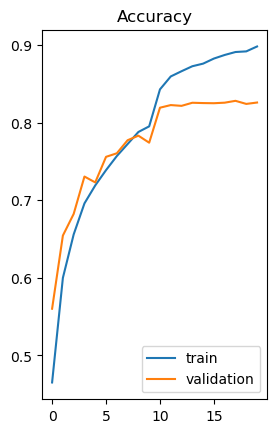

In [68]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label="train")
plt.plot(val_accuracy_history, label="validation")
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

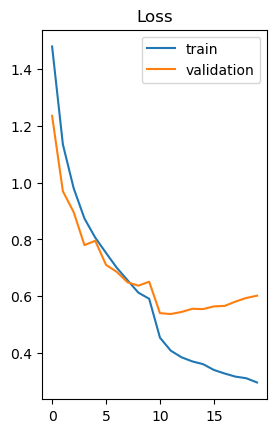

In [69]:
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="validation")
plt.legend()
plt.title('Loss')